In [25]:
#HARMFUL BRAIN ACTIVITY CLASSIFICATION PROJECT 
''' Sponsor : Ali Ibrahim 

    Team Members :  Estuardo Melendez,  Manuel Jimenez ---- """"input names

'''

' Sponsor : Ali Ibrahim \n\n    Team Members :  Estuardo Melendez,  Manuel Jimenez ---- """"input names\n\n'

In [ ]:
#Pre-processing of Data :  Estuardo & Manny 

# Import necessary libraries for data handling, signal processing, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt, spectrogram, iirnotch
from mne.preprocessing import ICA

#
## IF LIBRARIES ARE THROWING AN ERROR: 
## Open terminal and run: pip install 'name_of_library', e.g., pip install pandas 

# ATTENTION!!!!!! : Change the directory path to your dataset
#Manny C:/Users/Master/Documents/Project Data/hms-harmful-brain-activity-classification/train_eegs
#Estuardo /Users/estuardomelendez/Downloads/hms-harmful-brain-activity-classification/train_eegs
#Kevin "C:/Users/Kevin Tran/Documents/GitHub ED1/hms-harmful-brain-activity-classificationtrain_eegs/train_eegs"

# Directory containing the training EEG files (raw data)
train_eegs_dir = "C:/Users/Kevin Tran/Documents/GitHub ED1/hms-harmful-brain-activity-classificationtrain_eegs/train_eegs"


'''
hms-harmful-brain-activity-classification---- Data composition: 


train_eegs = Contains time-domain data
train_spectogram = Contains frequency-domain data
'''

# List all .parquet files in the specified directory
all_files = [os.path.join(train_eegs_dir, f) for f in os.listdir(train_eegs_dir) if f.endswith(".parquet")]

'''
## files_to_process can be changed to any integer between 1-100 for demo purposes or "ALL" for all files to be processed
   (processing all parquet files can take a long time)
'''
# Allows processing of either a subset of files ex (1-100) or all files in the directory
files_to_process = "ALL" # Change to "ALL" for processing all files

# which files to be processed 
if isinstance(files_to_process, int) and 1 <= files_to_process <= 100:
    files_to_process_list = all_files[:files_to_process]
elif files_to_process == "ALL":
    files_to_process_list = all_files
else:
    raise ValueError("files_to_process must be an integer between 1 and 100 or 'ALL'.")

# EEG Channel-to-Description Mapping: Maps channel names to their corresponding brain regions
channel_mapping = {
    "Fp1": "Frontal pole on the left hemisphere",
    "Fp2": "Frontal pole on the right hemisphere",
    "F3": "Frontal lobe on the left hemisphere",
    "F4": "Frontal lobe on the right hemisphere",
    "C3": "Central area on the left hemisphere",
    "C4": "Central area on the right hemisphere",
    "P3": "Parietal lobe on the left hemisphere",
    "P4": "Parietal lobe on the right hemisphere",
    "O1": "Occipital lobe on the left hemisphere",
    "O2": "Occipital lobe on the right hemisphere",
    "F7": "Anterior temporal lobe on the left hemisphere",
    "F8": "Anterior temporal lobe on the right hemisphere",
    "T3": "Mid-temporal lobe on the left hemisphere",
    "T4": "Mid-temporal lobe on the right hemisphere",
    "T5": "Posterior temporal lobe on the left hemisphere",
    "T6": "Posterior temporal lobe on the right hemisphere",
    "Fz": "Frontal midline",
    "Cz": "Central midline",
    "Pz": "Parietal midline"
}

# STEP 1: Notch filter function
def apply_notch_filter(signal, fs, freq=60.0, quality_factor=2.0):
    
    """
    Removes powerline noise at a specific frequency (default 60 Hz).
    Args:
        signal: The EEG signal (1D array).
        fs: Sampling frequency (Hz).
        freq: Frequency to remove (Hz, default = 60).
        quality_factor: Quality factor of the notch filter (default = 2.0).
    Returns:
        Filtered signal with the specified frequency removed.
    """

    b, a = iirnotch(w0=freq, Q=quality_factor, fs=fs)
    return filtfilt(b, a, signal)

# STEP 2: Bandpass Filter function
def apply_bandpass_filter(signal, fs, lowcut=0.5, highcut=40.0, order=5):
    
    """
    Retains signal components within a specific frequency range (default: 0.5–40 Hz).
    Args:
        signal: The EEG signal (1D array).
        fs: Sampling frequency (Hz).
        lowcut: Lower frequency bound (Hz, default = 0.5).
        highcut: Upper frequency bound (Hz, default = 40).
        order: Filter order (default = 5).
    Returns:
        Bandpass-filtered signal.
    """

    nyquist = 0.5 * fs # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# STEP 3: Artifact Removal with ICA (Optional)
def apply_ica(signal, fs, n_components=10):
    
    ica = ICA(n_components=n_components, random_state=42, max_iter='auto')
    signal_df = pd.DataFrame(signal)  # Convert signal to DataFrame for ICA compatibility
    ica.fit(signal_df)
    cleaned_signal = ica.apply(signal_df)
    return cleaned_signal.values  # Return cleaned signal as numpy array

# STEP 4: Normalize Signal
def normalize_signal(signal):
   
     return (signal - np.mean(signal)) / np.std(signal)

# STEP 5: Spectrogram Plot with Descriptions
def plot_spectrogram_with_description(signal, fs, channel_name, title_prefix="Spectrogram"):
    
    #Look up the description for the channel
    description = channel_mapping.get(channel_name, "Unknown channel")
    
    #Generate the spectrogram
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=128)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Power (dB)')
    
    #Add a descriptive title
    plt.title(f"{title_prefix} ({channel_name} - {description})")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, 100)  # Limit to 100 Hz for EEG signals
    plt.show()

# function for Time-domain Plot
def plot_time_domain(signal, fs, channel_name, title_prefix="Signal in Time Domain"):
    
    # Look up the description for the channel
    description = channel_mapping.get(channel_name, "Unknown channel")
    
    time = np.arange(len(signal)) / fs
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.title(f"{title_prefix} ({channel_name} - {description})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

# Preprocess and visualize a single File:
def process_single_file(file_path, fs=200):
    
    # Load data
    data = pd.read_parquet(file_path)
    print(f"Processing file: {file_path}")
    print(data.head())

    processed_data = {}
    for column in data.columns:
        raw_signal = data[column].values
        
        #Plot raw signal spectrogram
        plot_spectrogram_with_description(raw_signal, fs, channel_name=column, title_prefix="Raw Spectrogram")
        plot_time_domain(raw_signal, fs, channel_name=column, title_prefix="Raw Signal")
        
        #Apply notch filter and bandpass filter
        notch_filtered_signal = apply_notch_filter(raw_signal, fs, freq=60.0)
        bandpass_filtered_signal = apply_bandpass_filter(notch_filtered_signal, fs, lowcut=0.5, highcut=40.0)
        
        # Normalize the signal
        normalized_signal = normalize_signal(bandpass_filtered_signal)
        
        # (Optional) Apply ICA for artifact removal
        # cleaned_signal = apply_ica(normalized_signal, fs)  # Uncomment if ICA is needed
        
        #Plot processed signal spectrogram and time-domain signal
        plot_spectrogram_with_description(normalized_signal, fs, channel_name=column, title_prefix="Processed Spectrogram")
        plot_time_domain(normalized_signal, fs, channel_name=column, title_prefix="Processed Signal")
        
        # Store processed data
        processed_data[column] = normalized_signal

    # Convert processed data back to DataFrame
    processed_df = pd.DataFrame(processed_data)
    return processed_df

#Batch Process Files
def batch_process_files(file_list, output_dir=None, fs=200):
    
    for file_path in file_list:
        processed_df = process_single_file(file_path, fs=fs)
        
        # Optionally save the processed data
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, os.path.basename(file_path))
            processed_df.to_parquet(output_file)
            print(f"Saved processed file to: {output_file}")

''' 
ATTENTION: CHANGE OUTPUT DIRECTORY F  output_dir  TO THE FILEPATH OF THE FOLDER WHERE YOU WANT TO SAVE THE PRE-PROCESSED EEGS!!!
'''
# Output Directory for Processed Files
#estuardo /Users/estuardomelendez/Desktop/processed_eegs
#manny /Users/Master/Documents/Project Data/processed_eegs
output_dir = "C:/Users/Kevin Tran/Documents/Project Data/processed_eegs"  # CHANGE TO YOUR OWN DIRECTORY 

# Run Batch Processing with Sampling Frequency of 200 --- Can be changed according to professors instructions:

batch_process_files(files_to_process_list, output_dir=output_dir, fs=200)



In [ ]:
#Preprocessing Step with Parallel Processing: Kevin             Allows for quick execution of processing all 17300 files


import pandas as pd
import numpy as np
import os
from scipy.signal import butter, filtfilt, iirnotch
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# 📌 Define directories
raw_data_dir = r"C:\Users\Kevin Tran\Documents\GitHub ED1\hms-harmful-brain-activity-classificationtrain_eegs\train_eegs"
processed_data_dir = r"C:\Users\Kevin Tran\Documents\Project Data\processed_eegs"
os.makedirs(processed_data_dir, exist_ok=True)  # Ensure processed folder exists

# 📌 Verify if the EEG folder exists
if not os.path.exists(raw_data_dir):
    raise FileNotFoundError(f"🚨 ERROR: The directory {raw_data_dir} does not exist. Please check the path.")

# 📌 List all files to process
all_files = [os.path.join(raw_data_dir, f) for f in os.listdir(raw_data_dir) if f.endswith(".parquet")]

# 📌 Check if there are files to process
if len(all_files) == 0:
    raise FileNotFoundError(f"🚨 ERROR: No .parquet files found in {raw_data_dir}. Please check the folder contents.")

print(f"✅ Found {len(all_files)} .parquet files in {raw_data_dir}. Ready to process.\n")

# 📌 Define EEG Preprocessing Functions
def apply_notch_filter(signal, fs=200, freq=60.0, quality_factor=30):
    """Apply a notch filter to remove 60Hz noise."""
    b, a = iirnotch(w0=freq, Q=quality_factor, fs=fs)
    return filtfilt(b, a, signal)

def apply_bandpass_filter(signal, fs=200, lowcut=0.5, highcut=40.0, order=5):
    """Apply a bandpass filter to keep frequencies between 0.5Hz and 40Hz."""
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def normalize_signal(signal):
    """Normalize EEG signal to have zero mean and unit variance."""
    return (signal - np.mean(signal)) / np.std(signal)

# 📌 Function to preprocess a single EEG file
def process_single_file(file_path):
    try:
        # Load EEG Data
        data = pd.read_parquet(file_path)

        # Preprocess each EEG channel
        processed_data = {}
        for channel in data.columns:
            signal = data[channel].values
            signal = apply_notch_filter(signal)  # Remove powerline noise
            signal = apply_bandpass_filter(signal)  # Keep only relevant frequencies
            signal = normalize_signal(signal)  # Normalize the signal
            processed_data[channel] = signal
        
        # Save the processed data
        processed_df = pd.DataFrame(processed_data)
        output_file = os.path.join(processed_data_dir, os.path.basename(file_path))
        processed_df.to_parquet(output_file)
        return f"✅ Success: {os.path.basename(file_path)}"
    
    except Exception as e:
        return f"❌ Failed: {os.path.basename(file_path)} | Error: {e}"

# 📌 Threaded Batch Processing
def batch_process_files_threading(file_list, num_workers=os.cpu_count()//4):
    batch_size = 100  # Process files in batches of 100
    for i in range(0, len(file_list), batch_size):
        batch = file_list[i:i + batch_size]
        print(f"🚀 Processing Batch {i//batch_size+1}/{len(file_list)//batch_size+1} ({len(batch)} files)...")
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            results = list(tqdm(executor.map(process_single_file, batch), total=len(batch), desc=f"Batch {i//batch_size+1}"))

        # Summary of results for the current batch
        success = [res for res in results if res.startswith("✅")]
        failed = [res for res in results if res.startswith("❌")]
        print(f"✔️ Batch Summary: {len(success)} Success, {len(failed)} Failed\n")
        if failed:
            print(f"❌ Failed Files: {'; '.join(failed)}\n")

# 📌 Run Preprocessing
if __name__ == "__main__":
    print(f"Starting threaded processing for {len(all_files)} files...\n")
    batch_process_files_threading(all_files)
    print("✅ All EEG files have been processed and saved.\n")


In [5]:
#FEATURE EXTRACTION: Estuardo & Manny 
'''
Preliminary implementation for feature extraction, We divided the parquet eeg file into 2 second intervals
and extracted time domain features such as :[mean, variance, skewness, kurtosis, rms, delta power, theta power ,alpha power, beta power & gamma]

Me & Manny are still waiting on our Sposors feedback, you will find a eeg_features file which I recommend you open with the RAINBOW CSV extension
for visual studio.

#Remember to change file paths to your own dataset directory and comment out the previos one

'''

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import os

# CHANGE DIRECTORY TO YOU PROCESSED EEGS!!!!!
#Estuardo "/Users/estuardomelendez/Desktop/processed_eegs"
#Manny "C:/Users/Master/Documents/GitHub/ED1-PROJECT2024/processed_eegs" 
processed_eegs_dir = r"C:\Users\Kevin Tran\Documents\Project Data\processed_eegs"

processed_files = [os.path.join(processed_eegs_dir, f) for f in os.listdir(processed_eegs_dir) if f.endswith(".parquet")]


# Sampling frequency (Hz) and window size (in seconds)
fs = 200  # Sampling frequency (200 samples per second)
window_size_seconds = 2  # Duration of each window in seconds
window_size_samples = fs * window_size_seconds  # Convert window size to samples

#Function to split data into windows
def split_into_windows(signal, window_size):
    
    num_windows = len(signal) // window_size # Calculate number of complete windows
    windows = [signal[i * window_size:(i + 1) * window_size] for i in range(num_windows)]
    return windows

#Function to extract time-domain features
def extract_time_features(signal):
    
    features = {
        "mean": np.mean(signal),
        "variance": np.var(signal),
        "skewness": skew(signal),
        "kurtosis": kurtosis(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "zero_crossing_rate": np.sum(np.diff(np.sign(signal)) != 0) / len(signal)
    }
    return features

#function to extract frequency-domain features
def extract_frequency_features(signal, fs):
    
    freqs, psd = welch(signal, fs=fs, nperseg=256) #Compute PSD using Welch's method
    band_powers = {
        "delta_power": np.sum(psd[(freqs >= 0.5) & (freqs < 4)]),
        "theta_power": np.sum(psd[(freqs >= 4) & (freqs < 8)]),
        "alpha_power": np.sum(psd[(freqs >= 8) & (freqs < 13)]),
        "beta_power": np.sum(psd[(freqs >= 13) & (freqs < 30)]),
        "gamma_power": np.sum(psd[(freqs >= 30) & (freqs < 50)]),
        "spectral_entropy": -np.sum(psd * np.log(psd + 1e-10)) ## Avoid log(0) with small offset
    }
    return band_powers

#function to extract features from a single EEG file
def extract_features_from_file(file_path, fs, window_size_samples):
   
    # Load processed EEG data
    data = pd.read_parquet(file_path)
    
    # Extract features for each channel
    all_features = []
    for channel in data.columns:
        signal = data[channel].values
        
        # Split the signal into windows
        windows = split_into_windows(signal, window_size_samples)
        
        # Extract features from each window
        for i, window in enumerate(windows):
            time_features = extract_time_features(window)
            frequency_features = extract_frequency_features(window, fs)
            combined_features = {
                "file": os.path.basename(file_path),
                "channel": channel,
                "window": i,
                **time_features,
                **frequency_features
            }
            all_features.append(combined_features)
    
    # Return DataFrame with properly named columns
    return pd.DataFrame(all_features)

# Process all files and combine features by extracting features from all files in the directory
combined_features = []

for file_path in processed_files:
    print(f"Extracting features from: {file_path}")
    file_features = extract_features_from_file(file_path, fs, window_size_samples)
    combined_features.append(file_features)

# Combine features from all files into a single DataFrame
all_features_df = pd.concat(combined_features, ignore_index=True)

# Save extracted features to a CSV file for later use
#Estuardo "/Users/estuardomelendez/Desktop/eeg_features.csv"
#Manny /Users/Master/Documents/GitHub/ED1-PROJECT2024/eeg_features.csv
output_feature_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
all_features_df.to_csv(output_feature_file, index=False)

# Preview the extracted features
print(f"Features saved to: {output_feature_file}")
print("\nPreview of Extracted Features:")
print(all_features_df.head())





Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1000913311.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001369401.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001487592.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001717358.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002136740.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002142157.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002197945.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002379034.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002576868.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\proc

KeyboardInterrupt: 

In [8]:
#Feature Extraction with Parallel Processing

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# 📌 Directories
processed_eegs_dir = r"C:\Users\Kevin Tran\Documents\Project Data\processed_eegs"
output_feature_file = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features.csv"
os.makedirs(os.path.dirname(output_feature_file), exist_ok=True)  # Ensure output folder exists

processed_files = [os.path.join(processed_eegs_dir, f) for f in os.listdir(processed_eegs_dir) if f.endswith(".parquet")]

# Sampling frequency (Hz) and window size (in seconds)
fs = 200  # Sampling frequency
window_size_seconds = 2  # Duration of each window in seconds
window_size_samples = fs * window_size_seconds  # Convert window size to samples

# Function to split data into windows
def split_into_windows(signal, window_size):
    num_windows = len(signal) // window_size
    return [signal[i * window_size:(i + 1) * window_size] for i in range(num_windows)]

# Function to extract time-domain features
def extract_time_features(signal):
    return {
        "mean": np.mean(signal),
        "variance": np.var(signal),
        "skewness": skew(signal),
        "kurtosis": kurtosis(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "zero_crossing_rate": np.sum(np.diff(np.sign(signal)) != 0) / len(signal),
    }

# Function to extract frequency-domain features
def extract_frequency_features(signal, fs):
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    return {
        "delta_power": np.sum(psd[(freqs >= 0.5) & (freqs < 4)]),
        "theta_power": np.sum(psd[(freqs >= 4) & (freqs < 8)]),
        "alpha_power": np.sum(psd[(freqs >= 8) & (freqs < 13)]),
        "beta_power": np.sum(psd[(freqs >= 13) & (freqs < 30)]),
        "gamma_power": np.sum(psd[(freqs >= 30) & (freqs < 50)]),
        "spectral_entropy": -np.sum(psd * np.log(psd + 1e-10)),  # Avoid log(0)
    }

# Function to extract features from a single EEG file
def extract_features_from_file(file_path):
    try:
        data = pd.read_parquet(file_path)
        all_features = []

        for channel in data.columns:
            signal = data[channel].values
            windows = split_into_windows(signal, window_size_samples)

            for i, window in enumerate(windows):
                time_features = extract_time_features(window)
                frequency_features = extract_frequency_features(window, fs)
                combined_features = {
                    "file": os.path.basename(file_path),
                    "channel": channel,
                    "window": i,
                    **time_features,
                    **frequency_features,
                }
                all_features.append(combined_features)

        return pd.DataFrame(all_features)
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on failure

# Function for threaded batch processing
def batch_extract_features(file_list, num_workers=os.cpu_count()//4):
    batch_size = 100  # Process files in batches of 100
    combined_features = []

    for i in range(0, len(file_list), batch_size):
        batch = file_list[i:i + batch_size]
        print(f"🚀 Processing Batch {i//batch_size+1}/{len(file_list)//batch_size+1} ({len(batch)} files)...")
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            results = list(tqdm(executor.map(extract_features_from_file, batch), total=len(batch), desc=f"Batch {i//batch_size+1}"))

        # Combine features from the batch
        for df in results:
            if not df.empty:
                combined_features.append(df)

    return pd.concat(combined_features, ignore_index=True)

# 📌 Run Feature Extraction
if __name__ == "__main__":
    print(f"Starting feature extraction for {len(processed_files)} processed EEG files...\n")
    all_features_df = batch_extract_features(processed_files)
    all_features_df.to_csv(output_feature_file, index=False)
    print(f"✅ Feature extraction completed. Results saved to: {output_feature_file}\n")


Starting feature extraction for 17300 processed EEG files...

🚀 Processing Batch 1/174 (100 files)...


Batch 1: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


🚀 Processing Batch 2/174 (100 files)...


Batch 2: 100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


🚀 Processing Batch 3/174 (100 files)...


Batch 3: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


🚀 Processing Batch 4/174 (100 files)...


Batch 4: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


🚀 Processing Batch 5/174 (100 files)...


Batch 5: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


🚀 Processing Batch 6/174 (100 files)...


Batch 6: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


🚀 Processing Batch 7/174 (100 files)...


Batch 7: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


🚀 Processing Batch 8/174 (100 files)...


Batch 8: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 9/174 (100 files)...


Batch 9: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


🚀 Processing Batch 10/174 (100 files)...


Batch 10: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


🚀 Processing Batch 11/174 (100 files)...


Batch 11: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


🚀 Processing Batch 12/174 (100 files)...


Batch 12: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


🚀 Processing Batch 13/174 (100 files)...


Batch 13: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


🚀 Processing Batch 14/174 (100 files)...


Batch 14: 100%|██████████| 100/100 [01:16<00:00,  1.32it/s]


🚀 Processing Batch 15/174 (100 files)...


Batch 15: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


🚀 Processing Batch 16/174 (100 files)...


Batch 16: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


🚀 Processing Batch 17/174 (100 files)...


Batch 17: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


🚀 Processing Batch 18/174 (100 files)...


Batch 18: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


🚀 Processing Batch 19/174 (100 files)...


Batch 19: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


🚀 Processing Batch 20/174 (100 files)...


Batch 20: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


🚀 Processing Batch 21/174 (100 files)...


Batch 21: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


🚀 Processing Batch 22/174 (100 files)...


Batch 22: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


🚀 Processing Batch 23/174 (100 files)...


Batch 23: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 24/174 (100 files)...


Batch 24: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


🚀 Processing Batch 25/174 (100 files)...


Batch 25: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


🚀 Processing Batch 26/174 (100 files)...


Batch 26: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


🚀 Processing Batch 27/174 (100 files)...


Batch 27: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


🚀 Processing Batch 28/174 (100 files)...


Batch 28: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


🚀 Processing Batch 29/174 (100 files)...


Batch 29: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


🚀 Processing Batch 30/174 (100 files)...


Batch 30: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


🚀 Processing Batch 31/174 (100 files)...


Batch 31: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


🚀 Processing Batch 32/174 (100 files)...


Batch 32: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


🚀 Processing Batch 33/174 (100 files)...


Batch 33: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


🚀 Processing Batch 34/174 (100 files)...


Batch 34: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


🚀 Processing Batch 35/174 (100 files)...


Batch 35: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 36/174 (100 files)...


Batch 36: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


🚀 Processing Batch 37/174 (100 files)...


Batch 37: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


🚀 Processing Batch 38/174 (100 files)...


Batch 38: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


🚀 Processing Batch 39/174 (100 files)...


Batch 39: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


🚀 Processing Batch 40/174 (100 files)...


Batch 40: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


🚀 Processing Batch 41/174 (100 files)...


Batch 41: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


🚀 Processing Batch 42/174 (100 files)...


Batch 42: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


🚀 Processing Batch 43/174 (100 files)...


Batch 43: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


🚀 Processing Batch 44/174 (100 files)...


Batch 44: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


🚀 Processing Batch 45/174 (100 files)...


Batch 45: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


🚀 Processing Batch 46/174 (100 files)...


Batch 46: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 47/174 (100 files)...


Batch 47: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


🚀 Processing Batch 48/174 (100 files)...


Batch 48: 100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


🚀 Processing Batch 49/174 (100 files)...


Batch 49: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


🚀 Processing Batch 50/174 (100 files)...


Batch 50: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


🚀 Processing Batch 51/174 (100 files)...


Batch 51: 100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


🚀 Processing Batch 52/174 (100 files)...


Batch 52: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


🚀 Processing Batch 53/174 (100 files)...


Batch 53: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


🚀 Processing Batch 54/174 (100 files)...


Batch 54: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


🚀 Processing Batch 55/174 (100 files)...


Batch 55: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


🚀 Processing Batch 56/174 (100 files)...


Batch 56: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 57/174 (100 files)...


Batch 57: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


🚀 Processing Batch 58/174 (100 files)...


Batch 58: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


🚀 Processing Batch 59/174 (100 files)...


Batch 59: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


🚀 Processing Batch 60/174 (100 files)...


Batch 60: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


🚀 Processing Batch 61/174 (100 files)...


Batch 61: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


🚀 Processing Batch 62/174 (100 files)...


Batch 62: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


🚀 Processing Batch 63/174 (100 files)...


Batch 63: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


🚀 Processing Batch 64/174 (100 files)...


Batch 64: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


🚀 Processing Batch 65/174 (100 files)...


Batch 65: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


🚀 Processing Batch 66/174 (100 files)...


Batch 66: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


🚀 Processing Batch 67/174 (100 files)...


Batch 67: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


🚀 Processing Batch 68/174 (100 files)...


Batch 68: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


🚀 Processing Batch 69/174 (100 files)...


Batch 69: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


🚀 Processing Batch 70/174 (100 files)...


Batch 70: 100%|██████████| 100/100 [01:14<00:00,  1.33it/s]


🚀 Processing Batch 71/174 (100 files)...


Batch 71: 100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


🚀 Processing Batch 72/174 (100 files)...


Batch 72: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


🚀 Processing Batch 73/174 (100 files)...


Batch 73: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


🚀 Processing Batch 74/174 (100 files)...


Batch 74: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 75/174 (100 files)...


Batch 75: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


🚀 Processing Batch 76/174 (100 files)...


Batch 76: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


🚀 Processing Batch 77/174 (100 files)...


Batch 77: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


🚀 Processing Batch 78/174 (100 files)...


Batch 78: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


🚀 Processing Batch 79/174 (100 files)...


Batch 79: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


🚀 Processing Batch 80/174 (100 files)...


Batch 80: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


🚀 Processing Batch 81/174 (100 files)...


Batch 81: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


🚀 Processing Batch 82/174 (100 files)...


Batch 82: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


🚀 Processing Batch 83/174 (100 files)...


Batch 83: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


🚀 Processing Batch 84/174 (100 files)...


Batch 84:  49%|████▉     | 49/100 [00:40<00:56,  1.10s/it]C:\Users\Kevin Tran\AppData\Local\Temp\ipykernel_10848\3894915797.py:33: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skewness": skew(signal),
C:\Users\Kevin Tran\AppData\Local\Temp\ipykernel_10848\3894915797.py:34: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "kurtosis": kurtosis(signal),
Batch 84: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


🚀 Processing Batch 85/174 (100 files)...


Batch 85: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


🚀 Processing Batch 86/174 (100 files)...


Batch 86: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


🚀 Processing Batch 87/174 (100 files)...


Batch 87: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


🚀 Processing Batch 88/174 (100 files)...


Batch 88: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


🚀 Processing Batch 89/174 (100 files)...


Batch 89: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


🚀 Processing Batch 90/174 (100 files)...


Batch 90: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


🚀 Processing Batch 91/174 (100 files)...


Batch 91: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


🚀 Processing Batch 92/174 (100 files)...


Batch 92: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


🚀 Processing Batch 93/174 (100 files)...


Batch 93: 100%|██████████| 100/100 [01:06<00:00,  1.49it/s]


🚀 Processing Batch 94/174 (100 files)...


Batch 94: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


🚀 Processing Batch 95/174 (100 files)...


Batch 95: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


🚀 Processing Batch 96/174 (100 files)...


Batch 96: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


🚀 Processing Batch 97/174 (100 files)...


Batch 97: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 98/174 (100 files)...


Batch 98: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 99/174 (100 files)...


Batch 99: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


🚀 Processing Batch 100/174 (100 files)...


Batch 100: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


🚀 Processing Batch 101/174 (100 files)...


Batch 101: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


🚀 Processing Batch 102/174 (100 files)...


Batch 102: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


🚀 Processing Batch 103/174 (100 files)...


Batch 103: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


🚀 Processing Batch 104/174 (100 files)...


Batch 104: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


🚀 Processing Batch 105/174 (100 files)...


Batch 105: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


🚀 Processing Batch 106/174 (100 files)...


Batch 106: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


🚀 Processing Batch 107/174 (100 files)...


Batch 107: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


🚀 Processing Batch 108/174 (100 files)...


Batch 108: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


🚀 Processing Batch 109/174 (100 files)...


Batch 109: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


🚀 Processing Batch 110/174 (100 files)...


Batch 110: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


🚀 Processing Batch 111/174 (100 files)...


Batch 111: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


🚀 Processing Batch 112/174 (100 files)...


Batch 112: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


🚀 Processing Batch 113/174 (100 files)...


Batch 113: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


🚀 Processing Batch 114/174 (100 files)...


Batch 114: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


🚀 Processing Batch 115/174 (100 files)...


Batch 115: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


🚀 Processing Batch 116/174 (100 files)...


Batch 116: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


🚀 Processing Batch 117/174 (100 files)...


Batch 117: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


🚀 Processing Batch 118/174 (100 files)...


Batch 118: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


🚀 Processing Batch 119/174 (100 files)...


Batch 119: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


🚀 Processing Batch 120/174 (100 files)...


Batch 120: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


🚀 Processing Batch 121/174 (100 files)...


Batch 121: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


🚀 Processing Batch 122/174 (100 files)...


Batch 122: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


🚀 Processing Batch 123/174 (100 files)...


Batch 123: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


🚀 Processing Batch 124/174 (100 files)...


Batch 124: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


🚀 Processing Batch 125/174 (100 files)...


Batch 125: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


🚀 Processing Batch 126/174 (100 files)...


Batch 126: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


🚀 Processing Batch 127/174 (100 files)...


Batch 127: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


🚀 Processing Batch 128/174 (100 files)...


Batch 128: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


🚀 Processing Batch 129/174 (100 files)...


Batch 129: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


🚀 Processing Batch 130/174 (100 files)...


Batch 130: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


🚀 Processing Batch 131/174 (100 files)...


Batch 131: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


🚀 Processing Batch 132/174 (100 files)...


Batch 132: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


🚀 Processing Batch 133/174 (100 files)...


Batch 133: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 134/174 (100 files)...


Batch 134: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


🚀 Processing Batch 135/174 (100 files)...


Batch 135: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


🚀 Processing Batch 136/174 (100 files)...


Batch 136: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


🚀 Processing Batch 137/174 (100 files)...


Batch 137: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


🚀 Processing Batch 138/174 (100 files)...


Batch 138: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


🚀 Processing Batch 139/174 (100 files)...


Batch 139: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


🚀 Processing Batch 140/174 (100 files)...


Batch 140: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


🚀 Processing Batch 141/174 (100 files)...


Batch 141: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


🚀 Processing Batch 142/174 (100 files)...


Batch 142: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 143/174 (100 files)...


Batch 143: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


🚀 Processing Batch 144/174 (100 files)...


Batch 144: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


🚀 Processing Batch 145/174 (100 files)...


Batch 145: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


🚀 Processing Batch 146/174 (100 files)...


Batch 146: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


🚀 Processing Batch 147/174 (100 files)...


Batch 147: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


🚀 Processing Batch 148/174 (100 files)...


Batch 148: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


🚀 Processing Batch 149/174 (100 files)...


Batch 149: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


🚀 Processing Batch 150/174 (100 files)...


Batch 150: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


🚀 Processing Batch 151/174 (100 files)...


Batch 151: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


🚀 Processing Batch 152/174 (100 files)...


Batch 152: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


🚀 Processing Batch 153/174 (100 files)...


Batch 153: 100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


🚀 Processing Batch 154/174 (100 files)...


Batch 154: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


🚀 Processing Batch 155/174 (100 files)...


Batch 155: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


🚀 Processing Batch 156/174 (100 files)...


Batch 156: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


🚀 Processing Batch 157/174 (100 files)...


Batch 157: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


🚀 Processing Batch 158/174 (100 files)...


Batch 158: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


🚀 Processing Batch 159/174 (100 files)...


Batch 159: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


🚀 Processing Batch 160/174 (100 files)...


Batch 160: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


🚀 Processing Batch 161/174 (100 files)...


Batch 161: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


🚀 Processing Batch 162/174 (100 files)...


Batch 162: 100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


🚀 Processing Batch 163/174 (100 files)...


Batch 163: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


🚀 Processing Batch 164/174 (100 files)...


Batch 164: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


🚀 Processing Batch 165/174 (100 files)...


Batch 165: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


🚀 Processing Batch 166/174 (100 files)...


Batch 166: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


🚀 Processing Batch 167/174 (100 files)...


Batch 167: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


🚀 Processing Batch 168/174 (100 files)...


Batch 168: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


🚀 Processing Batch 169/174 (100 files)...


Batch 169: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


🚀 Processing Batch 170/174 (100 files)...


Batch 170: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


🚀 Processing Batch 171/174 (100 files)...


Batch 171: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


🚀 Processing Batch 172/174 (100 files)...


Batch 172: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


🚀 Processing Batch 173/174 (100 files)...


Batch 173: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


✅ Feature extraction completed. Results saved to: C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features.csv



In [7]:
#Feature extraction 2 test

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# 📌 Directories
processed_eegs_dir = r"C:\Users\Kevin Tran\Documents\Project Data\processed_eegs"
output_feature_dir = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\temp"
final_output_file = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features.csv"

os.makedirs(output_feature_dir, exist_ok=True)  # Ensure temp folder exists
os.makedirs(os.path.dirname(final_output_file), exist_ok=True)  # Ensure output folder exists

processed_files = [os.path.join(processed_eegs_dir, f) for f in os.listdir(processed_eegs_dir) if f.endswith(".parquet")]

# Sampling frequency (Hz) and window size (in seconds)
fs = 200  # Sampling frequency
window_size_seconds = 2  # Duration of each window in seconds
window_size_samples = fs * window_size_seconds  # Convert window size to samples

# Function to split data into windows
def split_into_windows(signal, window_size):
    num_windows = len(signal) // window_size
    return [signal[i * window_size:(i + 1) * window_size] for i in range(num_windows)]

# Function to extract time-domain features
def extract_time_features(signal):
    return {
        "mean": np.mean(signal),
        "variance": np.var(signal),
        "skewness": skew(signal),
        "kurtosis": kurtosis(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "zero_crossing_rate": np.sum(np.diff(np.sign(signal)) != 0) / len(signal),
    }

# Function to extract frequency-domain features
def extract_frequency_features(signal, fs):
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    return {
        "delta_power": np.sum(psd[(freqs >= 0.5) & (freqs < 4)]),
        "theta_power": np.sum(psd[(freqs >= 4) & (freqs < 8)]),
        "alpha_power": np.sum(psd[(freqs >= 8) & (freqs < 13)]),
        "beta_power": np.sum(psd[(freqs >= 13) & (freqs < 30)]),
        "gamma_power": np.sum(psd[(freqs >= 30) & (freqs < 50)]),
        "spectral_entropy": -np.sum(psd * np.log(psd + 1e-10)),  # Avoid log(0)
    }

# Function to extract features from a single EEG file
def extract_features_from_file(file_path):
    try:
        data = pd.read_parquet(file_path)
        all_features = []

        for channel in data.columns:
            signal = data[channel].values
            windows = split_into_windows(signal, window_size_samples)

            for i, window in enumerate(windows):
                time_features = extract_time_features(window)
                frequency_features = extract_frequency_features(window, fs)
                combined_features = {
                    "file": os.path.basename(file_path),
                    "channel": channel,
                    "window": i,
                    **time_features,
                    **frequency_features,
                }
                all_features.append(combined_features)

        output_file = os.path.join(output_feature_dir, os.path.basename(file_path).replace(".parquet", ".csv"))
        pd.DataFrame(all_features).to_csv(output_file, index=False)
        return f"✅ Success: {os.path.basename(file_path)}"
    except Exception as e:
        return f"❌ Failed: {os.path.basename(file_path)} | Error: {e}"

# Threaded batch processing
def batch_extract_features(file_list, num_workers=os.cpu_count()//4):
    batch_size = 100  # Process files in batches of 100
    for i in range(0, len(file_list), batch_size):
        batch = file_list[i:i + batch_size]
        print(f"🚀 Processing Batch {i//batch_size+1}/{len(file_list)//batch_size+1} ({len(batch)} files)...")
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            results = list(tqdm(executor.map(extract_features_from_file, batch), total=len(batch), desc=f"Batch {i//batch_size+1}"))

        # Print summary of results for the current batch
        success = [res for res in results if res.startswith("✅")]
        failed = [res for res in results if res.startswith("❌")]
        print(f"✔️ Batch Summary: {len(success)} Success, {len(failed)} Failed\n")
        if failed:
            print(f"❌ Failed Files: {'; '.join(failed)}\n")

# Merge all temporary files into a single CSV and clean up temporary files
def merge_temp_files_and_cleanup(output_dir, final_file):
    temp_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(".csv")]
    
    if not temp_files:
        print("❌ No temporary files found to merge!")
        return

    print(f"🚀 Merging {len(temp_files)} temporary files into final CSV...")
    combined_df = pd.concat([pd.read_csv(f) for f in temp_files], ignore_index=True)
    combined_df.to_csv(final_file, index=False)
    print(f"✅ Merged files into: {final_file}")

    # Clean up temporary files
    print("🧹 Cleaning up temporary files...")
    for temp_file in temp_files:
        try:
            os.remove(temp_file)
            print(f"🗑️ Deleted: {temp_file}")
        except Exception as e:
            print(f"❌ Failed to delete {temp_file}: {e}")

    print("✅ Cleanup completed!")

# Run Feature Extraction
if __name__ == "__main__":
    print(f"Starting feature extraction for {len(processed_files)} processed EEG files...\n")
    batch_extract_features(processed_files)
    print(f"✅ Feature extraction completed. Temporary files saved to: {output_feature_dir}\n")

    # Merge temporary files and clean up
    merge_temp_files_and_cleanup(output_feature_dir, final_output_file)
    print("✅ Feature extraction process fully completed!")


Starting feature extraction for 17300 processed EEG files...

🚀 Processing Batch 1/174 (100 files)...


Batch 1: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 2/174 (100 files)...


Batch 2: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 3/174 (100 files)...


Batch 3: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 4/174 (100 files)...


Batch 4: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 5/174 (100 files)...


Batch 5: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 6/174 (100 files)...


Batch 6: 100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 7/174 (100 files)...


Batch 7: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 8/174 (100 files)...


Batch 8: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 9/174 (100 files)...


Batch 9: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 10/174 (100 files)...


Batch 10: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 11/174 (100 files)...


Batch 11: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 12/174 (100 files)...


Batch 12: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 13/174 (100 files)...


Batch 13: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


✔️ Batch Summary: 100 Success, 0 Failed

🚀 Processing Batch 14/174 (100 files)...


Batch 14:  76%|███████▌  | 76/100 [01:01<00:19,  1.24it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import os
import matplotlib.pyplot as plt

# CHANGE DIRECTORY TO YOUR PROCESSED EEGS!!!
processed_eegs_dir = r"C:\Users\Kevin Tran\Documents\Project Data\processed_eegs"

# List all .parquet files in the specified directory
processed_files = [os.path.join(processed_eegs_dir, f) for f in os.listdir(processed_eegs_dir) if f.endswith(".parquet")]

# Sampling frequency (Hz) and window size (in seconds)
fs = 200  # Sampling frequency (200 samples per second)
window_size_seconds = 2  # Duration of each window in seconds
window_size_samples = fs * window_size_seconds  # Convert window size to samples


# Function to split data into fixed-size windows
def split_into_windows(signal, window_size):
    """
    Splits the input signal into fixed-size windows.
    Args:
        signal: The input EEG signal (1D array).
        window_size: Number of samples per window.
    Returns:
        A list of equally-sized signal windows.
    """
    num_windows = len(signal) // window_size  # Calculate the number of complete windows
    windows = [signal[i * window_size:(i + 1) * window_size] for i in range(num_windows)]  # Slice the signal
    return windows


# Function to extract time-domain features
def extract_time_features(signal):
    """
    Extracts statistical features from the signal in the time domain.
    Args:
        signal: The input EEG signal (1D array).
    Returns:
        A dictionary containing the computed features.
    """
    features = {
        "mean": np.mean(signal),  # Average value of the signal
        "variance": np.var(signal),  # Variability in the signal
        "skewness": skew(signal),  # Asymmetry of the signal
        "kurtosis": kurtosis(signal),  # "Peakedness" of the signal
        "rms": np.sqrt(np.mean(signal**2)),  # Root Mean Square of the signal
        "zero_crossing_rate": np.sum(np.diff(np.sign(signal)) != 0) / len(signal)  # Rate of zero crossings
    }
    return features


# Function to extract frequency-domain features
def extract_frequency_features(signal, fs):
    """
    Extracts frequency domain features from the signal using Welch's method.
    Args:
        signal: The input EEG signal (1D array).
        fs: Sampling frequency of the signal.
    Returns:
        A dictionary containing the computed frequency-domain features.
    """
    # Compute Power Spectral Density (PSD) using Welch's method
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    
    # Calculate band powers and spectral entropy
    band_powers = {
        "delta_power": np.sum(psd[(freqs >= 0.5) & (freqs < 4)]),  # Power in delta band (0.5–4 Hz)
        "theta_power": np.sum(psd[(freqs >= 4) & (freqs < 8)]),  # Power in theta band (4–8 Hz)
        "alpha_power": np.sum(psd[(freqs >= 8) & (freqs < 13)]),  # Power in alpha band (8–13 Hz)
        "beta_power": np.sum(psd[(freqs >= 13) & (freqs < 30)]),  # Power in beta band (13–30 Hz)
        "gamma_power": np.sum(psd[(freqs >= 30) & (freqs < 50)]),  # Power in gamma band (30–50 Hz)
        "spectral_entropy": -np.sum(psd * np.log(psd + 1e-10))  # Avoid log(0) with small offset
    }
    return band_powers


# Function to extract features from a single EEG file
def extract_features_from_file(file_path, fs, window_size_samples):
    """
    Processes an EEG file to extract both time-domain and frequency-domain features.
    Args:
        file_path: Path to the EEG file.
        fs: Sampling frequency of the signal.
        window_size_samples: Number of samples in each window.
    Returns:
        A DataFrame containing features for all channels and windows.
    """
    data = pd.read_parquet(file_path)  # Load EEG data
    print(f"Processing file: {file_path}")

    all_features = []  # List to store features for all windows and channels
    
    # Process each channel in the EEG data
    for channel in data.columns:
        signal = data[channel].values  # Get the signal for the current channel
        
        # Split the signal into windows
        windows = split_into_windows(signal, window_size_samples)
        
        # Extract features from each window
        for i, window in enumerate(windows):
            # Extract time-domain features
            time_features = extract_time_features(window)
            
            # Extract frequency-domain features
            frequency_features = extract_frequency_features(window, fs)
            
            # Combine features and add metadata
            combined_features = {
                "file": os.path.basename(file_path),  # File name
                "channel": channel,  # Channel name
                "window": i,  # Window index
                **time_features,  # Add time-domain features
                **frequency_features  # Add frequency-domain features
            }
            
            # Append to the list of all features
            all_features.append(combined_features)

    # Return the features as a DataFrame
    return pd.DataFrame(all_features)


# Process the first file to retrieve channel names
first_file_path = processed_files[0]
data = pd.read_parquet(first_file_path)
channels = data.columns.tolist()  # Get the list of channel names

# Process all files and combine features
combined_features = []

for file_path in processed_files:
    print(f"Extracting features from: {file_path}")
    file_features = extract_features_from_file(file_path, fs, window_size_samples)
    combined_features.append(file_features)

# Combine all features into a single DataFrame
all_features_df = pd.concat(combined_features, ignore_index=True)

# Save extracted features to a CSV file for later use
output_feature_file = r"C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
all_features_df.to_csv(output_feature_file, index=False)

# Preview the extracted features
print("\nExtracted Features:")
print(all_features_df.head())
print(f"Features saved to: {output_feature_file}")

# Visualize features for the first channel
first_channel_name = channels[0]  # Select the first channel
first_channel_features = all_features_df[all_features_df['channel'] == first_channel_name]

plt.plot(first_channel_features['window'], first_channel_features['delta_power'], label='Delta Power')
plt.title(f'Delta Power Across Windows - {first_channel_name}')
plt.xlabel('Window Index')
plt.ylabel('Delta Power')
plt.legend()
plt.show()


✅ Detailed anomalies saved to: C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_anomalies_detailed.csv
✅ EEG ID classifications saved to: C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_id_classifications.csv


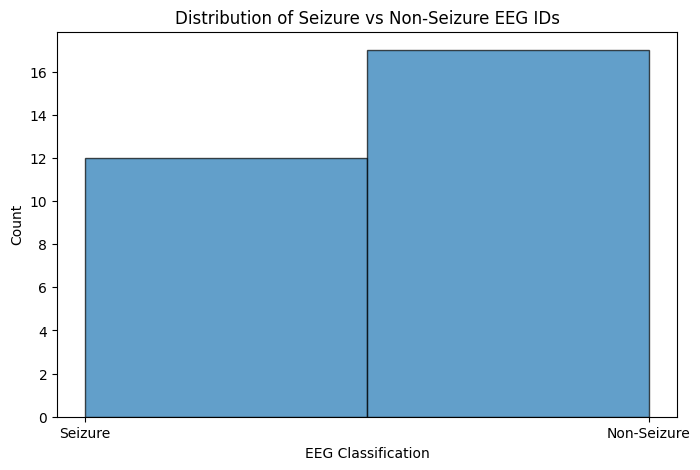

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 📌 Load the extracted EEG feature dataset
features_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
df_features = pd.read_csv(features_file)

# 📌 Extract EEG ID from the filename
df_features["eeg_id"] = df_features["file"].str.extract(r'(\d+)')  # Extract numeric EEG ID

# 📌 Drop Non-Numeric Columns Before Handling NaNs
numeric_columns = df_features.select_dtypes(include=[np.number]).columns
df_features[numeric_columns] = df_features[numeric_columns].fillna(df_features[numeric_columns].mean())  # Fill NaNs

# 📌 Drop non-numeric columns for Isolation Forest
X = df_features[numeric_columns].copy()

# 📌 Train the Isolation Forest Model
iso_forest = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
df_features["anomaly"] = iso_forest.fit_predict(X)  # -1 = Seizure-Like, 1 = Non-Seizure

# 📌 Save Detailed Anomalies for Each Channel
detailed_anomalies_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_anomalies_detailed.csv"
df_features.to_csv(detailed_anomalies_file, index=False)
print(f"✅ Detailed anomalies saved to: {detailed_anomalies_file}")

# 📌 Aggregate Anomalies by EEG ID
# If any channel in an EEG ID is classified as an anomaly (-1), the entire EEG ID is classified as Seizure
eeg_classifications = df_features.groupby("eeg_id")["anomaly"].apply(lambda x: -1 if (x == -1).any() else 1).reset_index()
eeg_classifications["classification"] = eeg_classifications["anomaly"].map({-1: "Seizure", 1: "Non-Seizure"})

# 📌 Save Results with EEG IDs
eeg_classifications_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_id_classifications.csv"
eeg_classifications.to_csv(eeg_classifications_file, index=False)
print(f"✅ EEG ID classifications saved to: {eeg_classifications_file}")

# 📊 Plot Distribution of EEG IDs (Seizure vs Non-Seizure)
plt.figure(figsize=(8, 5))
plt.hist(eeg_classifications["classification"], bins=2, edgecolor="black", alpha=0.7)
plt.xlabel("EEG Classification")
plt.ylabel("Count")
plt.title("Distribution of Seizure vs Non-Seizure EEG IDs")
plt.show()


In [ ]:
#machine learning test 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import joblib

# 📌 Define File Paths
train_labels_path = r"C:\Users\Kevin Tran\Documents\GitHub ED1\hms-harmful-brain-activity-classificationtrain_eegs\train.csv"
features_file_path = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features.csv"
processed_output_path = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features_processed.csv"
model_output_path = r"C:\Users\Kevin Tran\Documents\Project Data\seizure_model.pkl"

# 📌 Load Train Labels (Seizure vs. Non-Seizure)
df_labels = pd.read_csv(train_labels_path, dtype={'eeg_id': 'str'})  # Keep EEG ID as string to save memory
df_labels.rename(columns={"eeg_id": "file"}, inplace=True)

# 📌 Create a File to Store Processed Data (Instead of Keeping in RAM)
if os.path.exists(processed_output_path):
    os.remove(processed_output_path)  # Remove existing file to prevent duplicates

# 📌 Process EEG Features in Chunks & Write Directly to File
chunk_size = 50000  # Process 50,000 rows at a time
print("🚀 Processing EEG feature chunks...")

for i, chunk in enumerate(pd.read_csv(features_file_path, dtype={'file': 'str'}, chunksize=chunk_size)):
    chunk["file"] = chunk["file"].str.replace(".parquet", "", regex=False)  # Ensure filename consistency
    merged_chunk = chunk.merge(df_labels, on="file", how="inner")  # Merge with train.csv labels

    # Append to output CSV to avoid keeping everything in RAM
    merged_chunk.to_csv(processed_output_path, mode='a', index=False, header=(i == 0))  # Write header only once
    print(f"✅ Processed {len(merged_chunk)} rows. Total Chunks: {i+1}")

print(f"✅ All data successfully processed and saved to: {processed_output_path}")

# 📌 Load the Processed File (Much Smaller Than Before)
df = pd.read_csv(processed_output_path)

# 📌 Drop Unnecessary Columns
df.drop(columns=["file", "channel", "window"], inplace=True, errors="ignore")

# 📌 Define Features and Target Variable
X = df.drop(columns=["expert_consensus"])  # Features (EEG extracted values)
y = df["expert_consensus"].map({"seizure": 1, "non_seizure": 0})  # Convert labels to binary (1=Seizure, 0=Non-Seizure)

# 📌 Reduce Memory Usage by Converting to Float32
X = X.astype(np.float32)

# 📌 Train-Test Split (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Train a Machine Learning Model (Random Forest)
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 📌 Predictions
y_pred = model.predict(X_test)

# 📌 Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Save Model
joblib.dump(model, model_output_path)
print(f"✅ Model saved at: {model_output_path}")


✅ Processed 4396380 rows. Total Chunks: 34
✅ Processed 1212920 rows. Total Chunks: 35
✅ Processed 7854820 rows. Total Chunks: 36
✅ Processed 587480 rows. Total Chunks: 37
✅ Processed 515960 rows. Total Chunks: 38
✅ Processed 435260 rows. Total Chunks: 39
✅ Processed 568900 rows. Total Chunks: 40
✅ Processed 1004940 rows. Total Chunks: 41
✅ Processed 1033020 rows. Total Chunks: 42
✅ Processed 412020 rows. Total Chunks: 43
✅ Processed 498520 rows. Total Chunks: 44
✅ Processed 3413740 rows. Total Chunks: 45
✅ Processed 1244500 rows. Total Chunks: 46
✅ Processed 297520 rows. Total Chunks: 47
✅ Processed 9634280 rows. Total Chunks: 48
✅ Processed 6363100 rows. Total Chunks: 49
✅ Processed 532900 rows. Total Chunks: 50
✅ Processed 530520 rows. Total Chunks: 51
✅ Processed 369540 rows. Total Chunks: 52
✅ Processed 318280 rows. Total Chunks: 53
✅ Processed 5396140 rows. Total Chunks: 54
✅ Processed 388300 rows. Total Chunks: 55
✅ Processed 526440 rows. Total Chunks: 56
✅ Processed 356860 rows.

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import joblib

# 📌 Define Correct File Paths
features_file_path = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features.csv"
train_labels_path = r"C:\Users\Kevin Tran\Documents\GitHub ED1\hms-harmful-brain-activity-classificationtrain_eegs\train.csv"
model_output_path = r"C:\Users\Kevin Tran\Documents\Project Data\seizure_model.pkl"

# 📌 Load EEG Feature Extraction Data
print("🚀 Loading EEG Feature Data...")
df = pd.read_csv(features_file_path, dtype={'file': 'str'}, engine="python", on_bad_lines="skip")

# 📌 Drop Unnecessary Columns
df.drop(columns=["channel", "window"], inplace=True, errors="ignore")

# ✅ Remove `.parquet` from EEG File Names & Ensure Consistency
df["file"] = df["file"].str.replace(".parquet", "", regex=False).str.strip()

# 📌 Aggregate Data: Group by EEG ID & Compute Mean of Features
print("🔄 Grouping EEG Data by ID...")
df_grouped = df.groupby("file", as_index=False).mean()

# 📌 Load Train Labels (Seizure vs. Non-Seizure)
df_labels = pd.read_csv(train_labels_path, dtype={'eeg_id': 'str'})  # Ensure EEG IDs are strings
df_labels.rename(columns={"eeg_id": "file"}, inplace=True)

# ✅ Standardize & Strip Spaces from EEG IDs
df_grouped["file"] = df_grouped["file"].astype(str).str.strip()
df_labels["file"] = df_labels["file"].astype(str).str.strip()

# ✅ DEBUG: Print Number of Matching EEG IDs Before Merging
matching_ids = set(df_grouped["file"]).intersection(set(df_labels["file"]))
print(f"🔍 {len(matching_ids)} EEG IDs match between feature extraction & train.csv.")

# ✅ Merge EEG Features with Labels (Keeping Only Matching EEGs)
df_grouped = df_grouped.merge(df_labels, on="file", how="inner")

# ✅ FIX: Filter Only Valid Labels ("seizure" or "non_seizure")
df_grouped = df_grouped[df_grouped["expert_consensus"].isin(["seizure", "non_seizure"])]

# 📌 Define Features & Target
X = df_grouped.drop(columns=["file", "expert_consensus"])
y = df_grouped["expert_consensus"].map({"seizure": 1, "non_seizure": 0})  # Convert labels to binary

# ✅ DEBUG: Ensure No NaN in `y` (Final Check)
if y.isna().sum() > 0:
    print("🚨 ERROR: NaN values still found in `y`. Investigating...")
    print(df_grouped[df_grouped["expert_consensus"].isna()].head(20))  # Print problematic rows
    raise ValueError(f"🚨 Found {y.isna().sum()} NaN values in `y`!")

# 📌 Reduce Memory Usage
X = X.astype(np.float16)  # Convert to `float16` to save memory

# 📌 Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Notify When Test Data is Being Processed
print(f"🔔 {len(X_test)} EEG IDs selected for testing... Model Training Begins! 🚀")

# 📌 Train a Machine Learning Model (Random Forest - Optimized for Memory)
model = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)  # Fewer trees, max depth to save RAM
model.fit(X_train, y_train)

# 📌 Predictions
y_pred = model.predict(X_test)

# 📌 Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Save Model
joblib.dump(model, model_output_path)
print(f"✅ Model saved at: {model_output_path}")


🚀 Loading EEG Feature Data...


KeyboardInterrupt: 

In [4]:
import pandas as pd

file_path = r"C:\Users\Kevin Tran\Documents\Project Data\feature extractions\eeg_features.csv"

# Read first 20 rows without loading entire file
df = pd.read_csv(file_path, nrows=20)
print(df.head())


                 file channel  window      mean  variance  skewness  kurtosis  \
0  1000913311.parquet     Fp1       0  0.171571  2.755021 -0.352579 -0.886731   
1  1000913311.parquet     Fp1       1  0.124090  1.608011 -0.210350 -0.174512   
2  1000913311.parquet     Fp1       2 -0.077944  0.829873  0.301777 -0.110549   
3  1000913311.parquet     Fp1       3 -0.014668  0.654192 -0.581156  0.979690   
4  1000913311.parquet     Fp1       4  0.038659  0.498066  0.602220  1.722742   

        rms  zero_crossing_rate  delta_power  theta_power  alpha_power  \
0  1.668669              0.0275     3.634739     0.076030     0.020288   
1  1.274131              0.0450     1.865378     0.034776     0.028235   
2  0.914302              0.0850     0.750413     0.139047     0.033155   
3  0.808955              0.0775     0.536515     0.081503     0.075334   
4  0.706796              0.1125     0.345207     0.040682     0.032545   

   beta_power  gamma_power  spectral_entropy  
0    0.196447     0.0